## Contents
* [Diffuse scattering removal](#diffuse)

In [447]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import functools
from importlib import reload

from scipy.ndimage import gaussian_filter as gf
from scipy.interpolate import NearestNDInterpolator

from xrdc import xrdutils as xdu
from xrdc import source_separation as sep

def compose(*functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions, lambda x: x)

In [448]:
# !pip install powerbox

In [722]:
####
# geometry stuff
####
def _twotheta(x, y):
    return np.arccos((x * np.sin(alpha) + D * np.cos(alpha)) / np.sqrt(D**2 + x**2 + y**2))

def _phi(x, y):
    return (np.sign(x * np.cos(alpha) - D * np.sin(alpha)) * 
            np.arccos(-y / 
                np.sqrt(y**2 +
                    (x * np.cos(alpha) - D * np.sin(alpha))**2
                       )
                     ))

def interp2d(x, y, z):
    interp = NearestNDInterpolator(list(zip(x, y)), z)
    return interp

def mk_get_idx(min_twotheta, max_twotheta, Ntheta):
    def f(twotheta_nongrid):
        i = (((twotheta_nongrid - min_twotheta) / (max_twotheta - min_twotheta)) * Ntheta).astype(int)
        ref = np.ones_like(i)
        axis = 2

        amin = np.min(np.dstack([ref * (Ntheta - 1), i]), axis = axis)
        amax = np.max(np.dstack([0 * ref, amin]), axis = axis)
        return amax
    return f

def mk_mask(patterns, nthresh = .05, mask_smooth = (0.5, 1), pre_smooth = (0., 1.7)):
    print(pre_smooth)
    zeromask = (patterns != 0)
    slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25, threshold = 20,
                                smooth_q = pre_smooth, background_after_filter = False,
                                
                                smooth_q_background = 5)
    background = slow_q
    #absnoise = np.abs(fast_T) / (np.abs(np.mean((patterns), axis = 0)) + 1e-9)
    #absnoise = np.abs(fast_T) / (np.abs(np.mean((patterns - background), axis = 0)) + 1e-9)
    absnoise = (np.abs(fast_T) * (zeromask)) / (np.mean(np.abs((patterns - background) * zeromask), axis = 0) + 1e-9)
    # account for pixels where there is no signal
    normalization = patterns.shape[0] / (1 + (patterns != 0).sum(axis = 0))
    absnoise = absnoise / normalization
    # absnoise = np.abs(fast_T) / (np.mean(np.abs(fast_T), axis = 0) + 1e-9)
    mask = gf(absnoise, mask_smooth) > nthresh
    return mask | (~zeromask), absnoise

def denoise(patterns, method = 'linear', **kwargs):
    zeromask = (patterns != 0)
    mask, absnoise = mk_mask(patterns, **kwargs)
    if method == 'linear':
        #denoised = sep.interprows(patterns.T, (~mask).T, fill_value="extrapolate").T
        denoised = sep.interprows(patterns.T, (~mask).T, fill_value= np.percentile(patterns, 50)).T
    elif method == 'neighbor':
        denoised = sep.NDinterpolation((~mask) * patterns)
    else:
        raise ValueError
    denoised = denoised * zeromask
    return denoised, mask, absnoise

In [450]:
reload(xdu)

<module 'xrdc.xrdutils' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/xrdutils.py'>

In [666]:
####
# Pymatgen stuff
####
def get_structure(p):
    #p path to CIF
    structure = pm.core.Structure.from_file(p) #read in structure
    return structure

def structure_pat(structure, sigma = .01, wavelength = 1.54184):
    xrd = XRDCalculator(wavelength) #initiate XRD calculator (can specify various options here)
    pat = xrd.get_pattern(structure)
    q, i = xdu.to_q(pat.x, lamb = wavelength), pat.y
    ii = xdu.mk_pattern(i, q, sigma)
    return ii

paths = glob("NbCoSn/*")

import pymatgen as pm
from pymatgen.analysis.diffraction.xrd import XRDCalculator


# pat from cif path
get_pat = compose(structure_pat, get_structure)

structures = [get_structure(p) for p in paths]
pats = [get_pat(p) for p in paths]
pat= pats[1]

/home/ollie/anaconda3/lib/python3.8/site-packages/pymatgen-2022.1.9-py3.8-linux-x86_64.egg/pymatgen/io/cif.py:1164: UserWarning: Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.
  warnings.warn("Issues encountered while parsing CIF: %s" % "\n".join(self.warnings))


In [667]:
Nphi = 200
#Define grids for two theta and phi
twotheta = xdu.to_twotheta(xdu.q_grid) * (np.pi / 180)

phi = np.linspace(-np.pi, np.pi, num = Nphi + 1)[1:]
tt, phiphi = np.meshgrid(twotheta, phi)
theta_phi_shape = tt.shape
ttgrid, phiphigrid = tt, phiphi


II = np.hstack([pat for _ in range(theta_phi_shape[0])]).reshape(theta_phi_shape)
variation = (2 + np.sin(phi * 3)) / 3
II = (II * variation[:, None]).ravel()
tt, phiphi = tt.ravel(), phiphi.ravel()

alpha, D = 0., 50
scale = 5
N = 100
dn = 1 / scale
offset = 0#1e-6

gridx = np.arange(-N, N, dn) + offset
gridy = np.arange(-N, N, dn) + offset
xx, yy = np.meshgrid(gridx, gridy)

min_twotheta = twotheta.min()
max_twotheta = twotheta.max()
Ntheta = len(twotheta)

_twotheta_idx = mk_get_idx(min_twotheta, max_twotheta, Ntheta)
    
min_phi = phi.min()
max_phi = phi.max()
_phi_idx = mk_get_idx(min_phi, max_phi, Nphi)

# # test
# _twotheta_idx(np.array([[1.111111, -100, 100], [1.111111, -100, 100]]))
# _twotheta_idx(np.array([1.111111, -100, 100]))
# _phi_idx(np.array([1.111111, -100, 100]))

twotheta_nongrid = _twotheta(xx, yy)
phi_nongrid = _phi(xx, yy)

Itheta_phi_full = II.reshape(theta_phi_shape)
noisemap = np.zeros_like(Itheta_phi_full)
sigmap = np.zeros_like(Itheta_phi_full)

itt = _twotheta_idx(twotheta_nongrid)

iphi = _phi_idx(phi_nongrid)

In [668]:
tt_det = _twotheta(xx, yy)
phi_det = _phi(xx, yy)

In [669]:
# credit https://github.com/PabloVD/MapGenerator

import matplotlib.pyplot as plt
import numpy as np
import powerbox as pbox
from scipy import interpolate, ndimage

#--- Parameters for GRF---#


# Number of bins per dimension
boxsize = (max(xx.shape) + 1) // 2#xx.shape[0] // 2
# Number of bins per dimension in the high resolution  box
highboxsize = 2*boxsize
# Threshold for the sea level
threshold = 0.52
# Sigma for the gaussian smoothing
sigma = 5. 
# Initial random seed
llavor = 0
# Spectral index for the power spectrum
indexlaw = -.4

# Define power spectrum as a power law with an spectral index indexlaw
# With lower the spectral indexes, small structures are removed
def powerspec(k,indexlaw):
    return k**indexlaw

# Filter the field with a gaussian window
def smooth_field(field,sigmagauss,gridsize=boxsize):

    x, y = np.linspace(0,field.shape[0],num=field.shape[0]), np.linspace(0,field.shape[1],num=field.shape[1])

    # Interpolation
    f = interpolate.interp2d(x,y,field,kind="linear")

    qx = np.linspace(x[0],x[-1], num = gridsize)
    qy = np.linspace(y[0],y[-1], num = gridsize)

    # Filtering
    smooth = ndimage.filters.gaussian_filter(f(qx,qy),sigmagauss)
    return smooth

# Remove regions below sea level
def mainland(field,threshold):
    for i, row in enumerate(field):
        for j, el in enumerate(row):
            if el<threshold:   field[i,j]=0.
    return field

# Normalize the values of the field between 0 and 1
def normalize_field(field):
    min, max = np.amin(field), np.amax(field)
    newfield = (field-min)/(max-min)
    return newfield

# Generate a map of islands applying different processes:
# 1. Generate a random gaussian field given a power spectrum
# 2. Normalize the field between 0 and 1
# 3. Smooth the field with a gaussian filter
# 4. Retain only the mainland above a certain threshold
def generate_map(llavor,indexlaw,sigma,threshold):
    np.random.seed(seed=llavor)
    field = pbox.powerbox.PowerBox(boxsize, lambda k: powerspec(k,indexlaw), dim=2, boxlength=100.).delta_x()
    field = normalize_field(field)
    field = smooth_field(field,sigma,gridsize=highboxsize)
    field = mainland(field,threshold)
    return field

def get_speckle(noise_scale = .2, smooth = 1.5):
    print(xx.shape)
    splotches = generate_map(llavor,indexlaw,sigma,threshold)
    splotches = gf(mainland(splotches, .04), smooth)
    splotches = noise_scale * splotches * (detsignal.mean() / splotches.mean())
    splotches = splotches[:xx.shape[0], :xx.shape[1]]
    return splotches

(1000, 1000)


/home/ollie/anaconda3/lib/python3.8/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


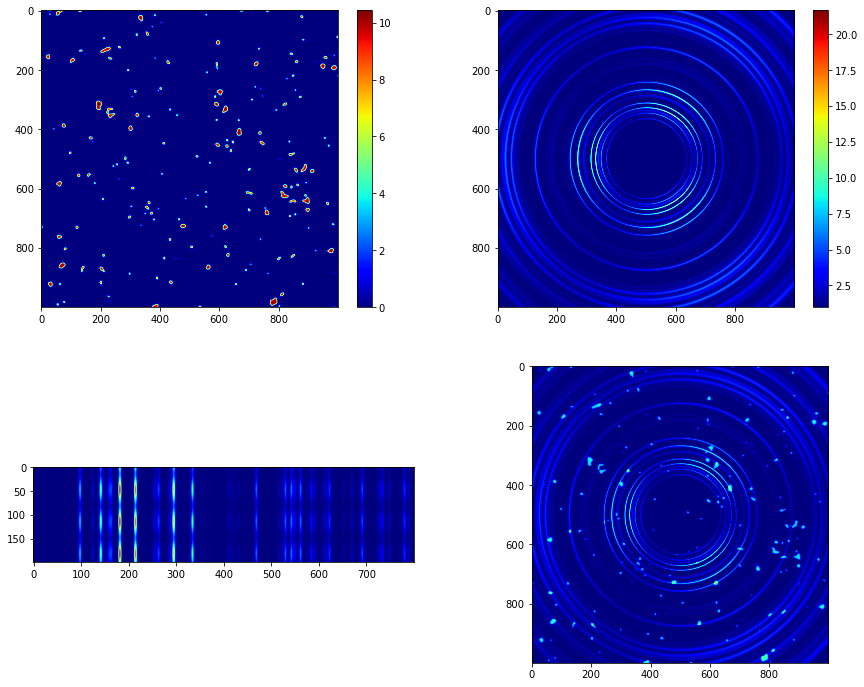

In [670]:
def ttchi_to_det(tt_det, phi_det, II):
    interp = interp2d(tt, phiphi, II)
    return interp(tt_det, phi_det)

def det_to_ttchi(detsignal):
    sigmap = np.zeros_like(Itheta_phi_full)
    sigmap[iphi, itt] += detsignal
    return sigmap

plt.rcParams["figure.figsize"]=(15, 12)

detsignal = ttchi_to_det(tt_det, phi_det, II)#interp(tt_det, phi_det)

splotches = get_speckle(.2, 1.5)

a, b = 2, 2

plt.subplot(a, b, 1)
plt.imshow(splotches, cmap = 'jet')
plt.colorbar()



plt.subplot(a, b, 2)
plt.imshow((1 + detsignal), cmap = 'jet')
plt.colorbar()

plt.subplot(a, b, 3)
plt.imshow(II.reshape(theta_phi_shape), aspect = 1., cmap = 'jet')

plt.subplot(a, b, 4)
plt.imshow(detsignal + splotches, cmap = 'jet')

Text(0, 0.5, 'phi')

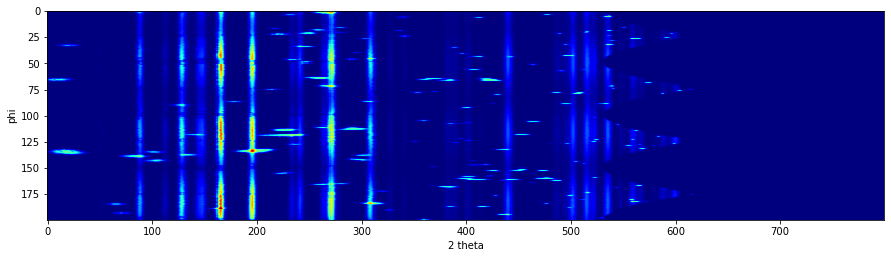

In [671]:
noisemap[iphi, itt] += splotches
sigmap[iphi, itt] += detsignal

totalmap = sigmap + noisemap
patterns = totalmap
patterns = gf(patterns, (0.5, 1.))

plt.imshow(patterns, cmap = 'jet', aspect = 1, interpolation='none')
plt.xlabel('2 theta')
plt.ylabel('phi')

#plt.hlines(133, 0, 750)

(0, 0)


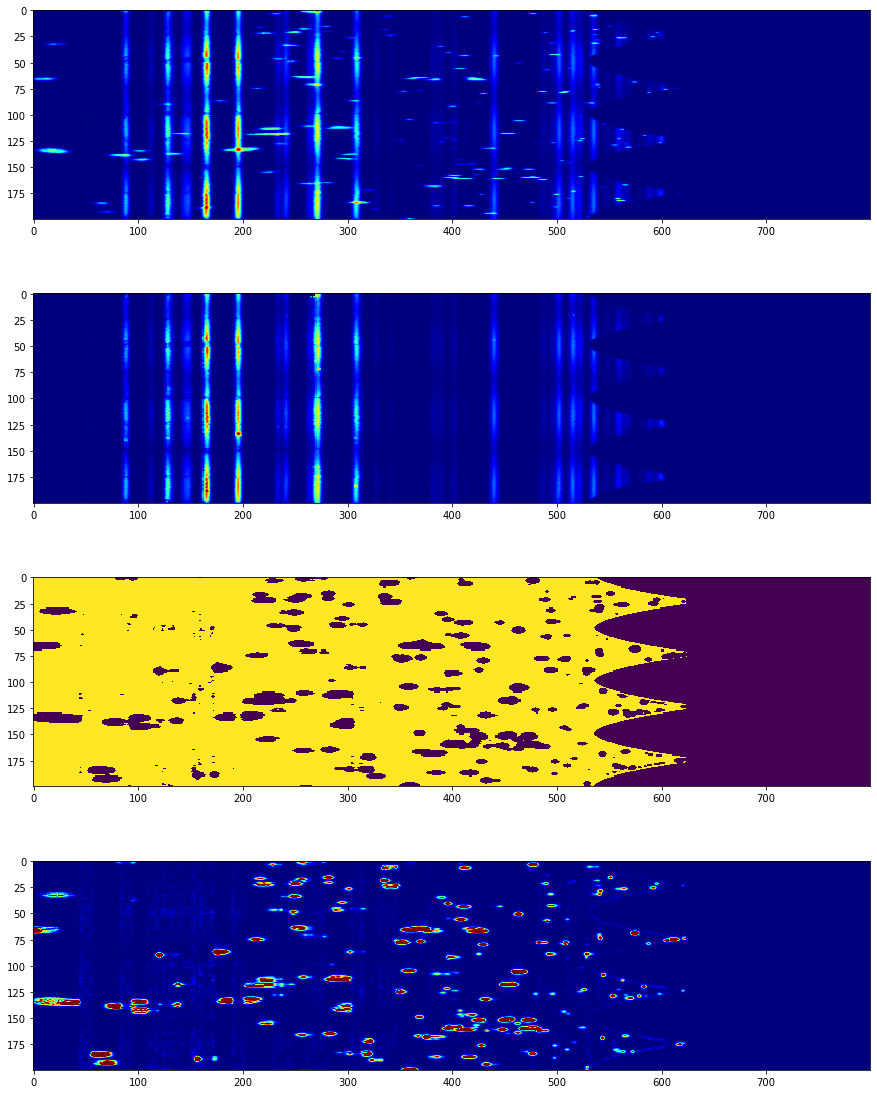

In [468]:
from scipy.interpolate import interp1d
plt.rcParams["figure.figsize"]=(15, 20)

a, b = 4, 1
plt.subplot(a, b, 1)
plt.imshow(patterns, cmap = 'jet', vmax = 20)
# plt.colorbar()

#denoised = sep.NDinterpolation((~mask) * patterns)

denoised, mask, absnoise = denoise(patterns, method = 'linear', nthresh = 0.15, pre_smooth = (0, 1.))
#denoised = sep.interprows(gf(patterns, (0., 0.)).T, (~mask).T, fill_value="extrapolate").T

plt.subplot(a, b, 2)
plt.imshow(denoised, cmap = 'jet', vmax = 20, interpolation = 'none')
# plt.colorbar()

plt.subplot(a, b, 3)
plt.imshow(((~mask)), interpolation = 'none')

plt.subplot(a, b, 4)
plt.imshow(absnoise, cmap = 'jet', vmax = 3)

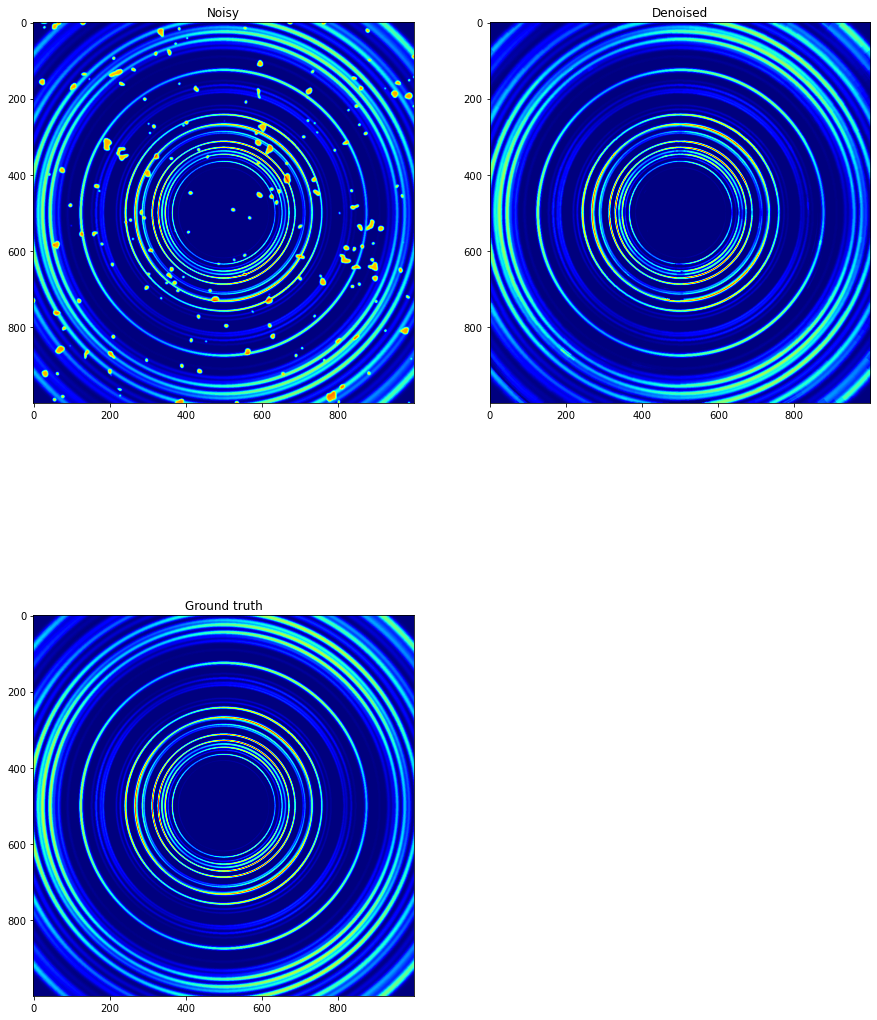

In [469]:
# remap the denoised data into detector space
ixx, iyy = np.indices(xx.shape)

detremap = np.zeros(xx.shape)

detremap[ixx, iyy] += denoised[iphi, itt]

plt.rcParams["figure.figsize"]=(15, 20)

a, b = 2, 2

plt.subplot(a, b, 1)
plt.title('Noisy')
plt.imshow(np.log(1 + detsignal + splotches), cmap = 'jet')

plt.subplot(a, b, 2)
plt.title("Denoised")
plt.imshow(np.log(1 + detremap), cmap = 'jet')

plt.subplot(a, b, 3)
plt.title("Ground truth")
plt.imshow(np.log(1 + detsignal), cmap = 'jet')

In [457]:
a, b = 1, 2

from scipy.fft import fft2, fftshift

def do(Itmp, aspect = 1):
    #Itmp = totalmap#I[110:-110, 20:-50]
    tmp = (fft2(Itmp))

    tmp0 = tmp
    tmp = np.real(tmp * np.conjugate(tmp))

    plt.subplot(a, b, 1)
    plt.imshow(np.log(1 + Itmp), aspect = aspect)

    plt.subplot(a, b, 2)
    plt.imshow(np.log(1 + fftshift(tmp)), cmap = 'jet', aspect = aspect, interpolation = 'none')
    return fftshift(tmp), fftshift(tmp0), fftshift(np.angle(tmp0))
#plt.colorbar()

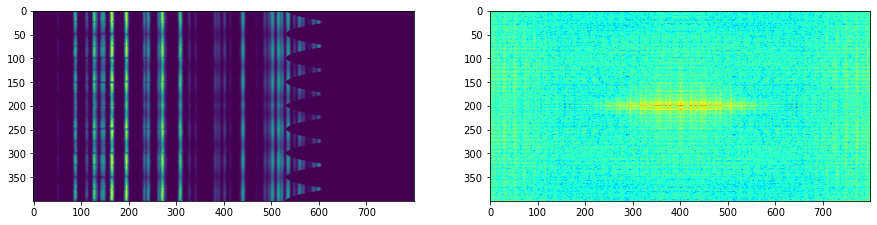

In [304]:
do(np.vstack((sigmap[::-1], sigmap)));

In [359]:
tmp2 = np.vstack((totalmap[::-1], totalmap))

In [370]:
(np.real(ifft2(np.real(fft2(totalmap)))) - totalmap).max()

11.968497142983251

In [372]:
(np.real(ifft2(np.real(fft2(tmp2)))) - tmp2).max()

11.968497142983253

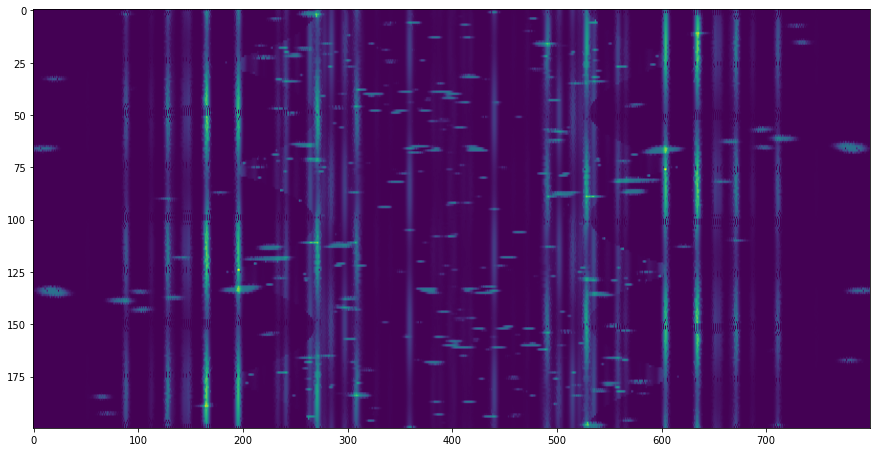

In [375]:
plt.imshow(np.real(ifft2(np.real(fft2(totalmap)))), aspect = 2)

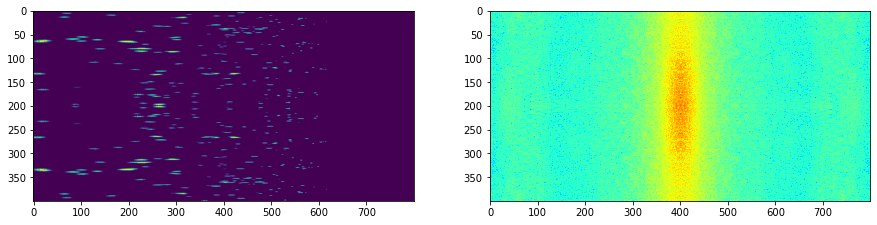

In [303]:
do(np.vstack((noisemap[::-1], noisemap)));

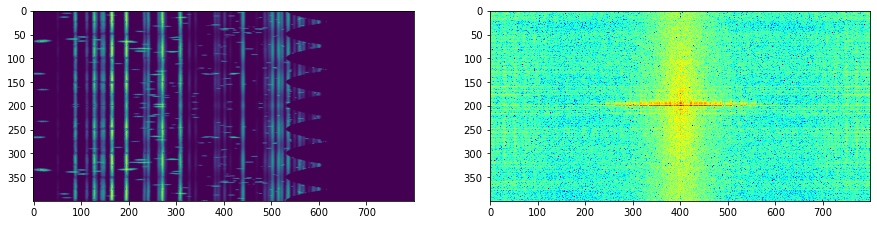

In [338]:
tmp, tmp0, phase = do(np.vstack((totalmap[::-1], totalmap)))

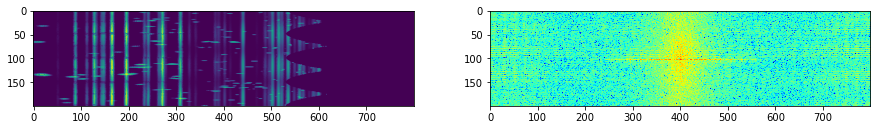

In [314]:
tmp, tmp0, phase = do(totalmap)

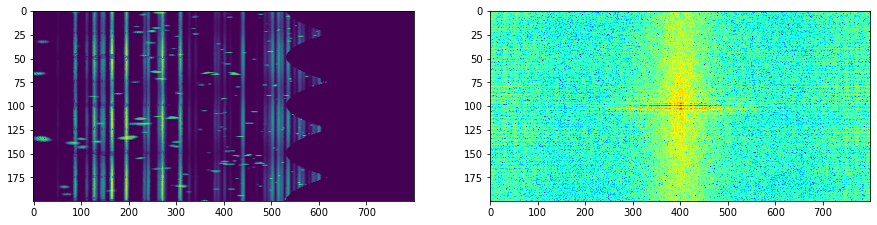

In [311]:
do(((totalmap)), 2);

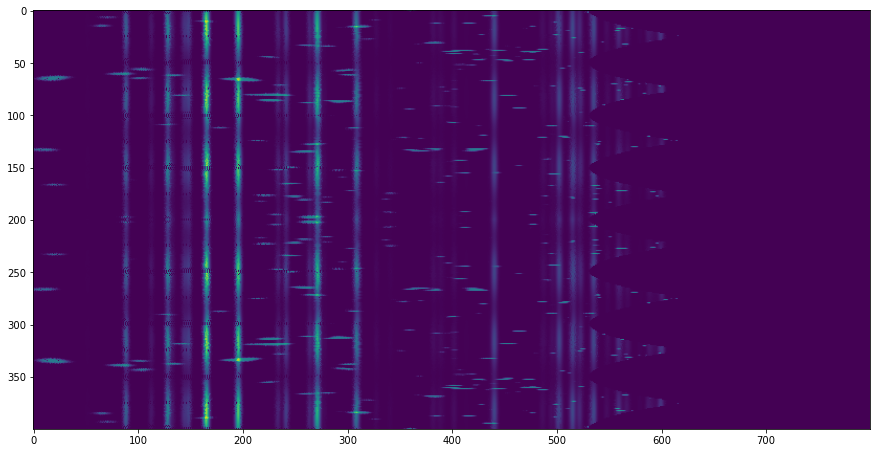

In [301]:
plt.imshow(np.vstack((totalmap[::-1], totalmap)))

In [331]:
tmp0[:170, :] = 0
tmp0[230:, :] = 0

In [315]:
tmp0[:80, 350:450] = 0
tmp0[120:, 350:450] = 0

In [322]:
tmp0[:170, 350:450] = 0
tmp0[230:, 350:450] = 0

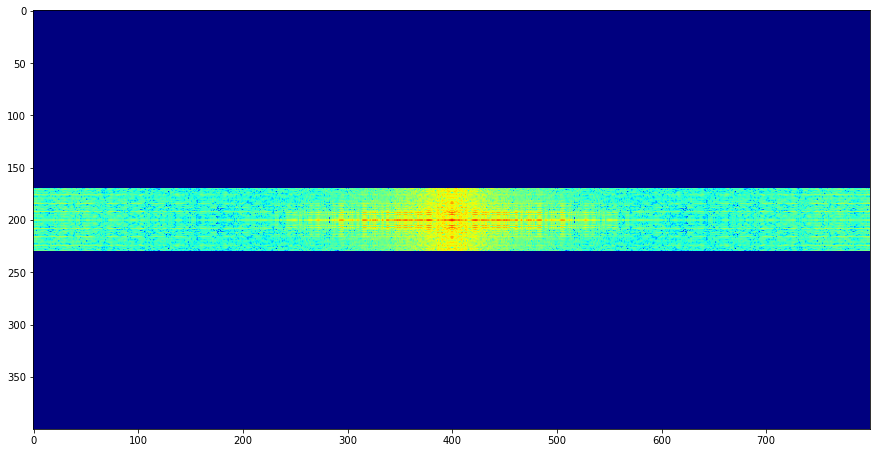

In [332]:
plt.imshow(np.log(1 + np.real(tmp0 * np.conjugate(tmp0))), cmap = 'jet')

In [333]:
from scipy.fft import ifftshift, ifft2

In [334]:
tmp0 = ifft2(ifftshift(tmp0))
tmp0 = np.real(tmp0 * np.conjugate(tmp0))

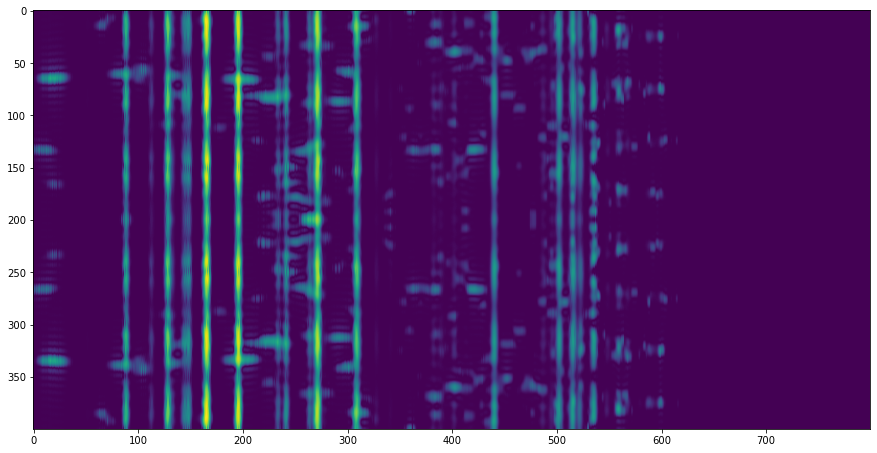

In [335]:
plt.imshow(np.log(1 + tmp0))

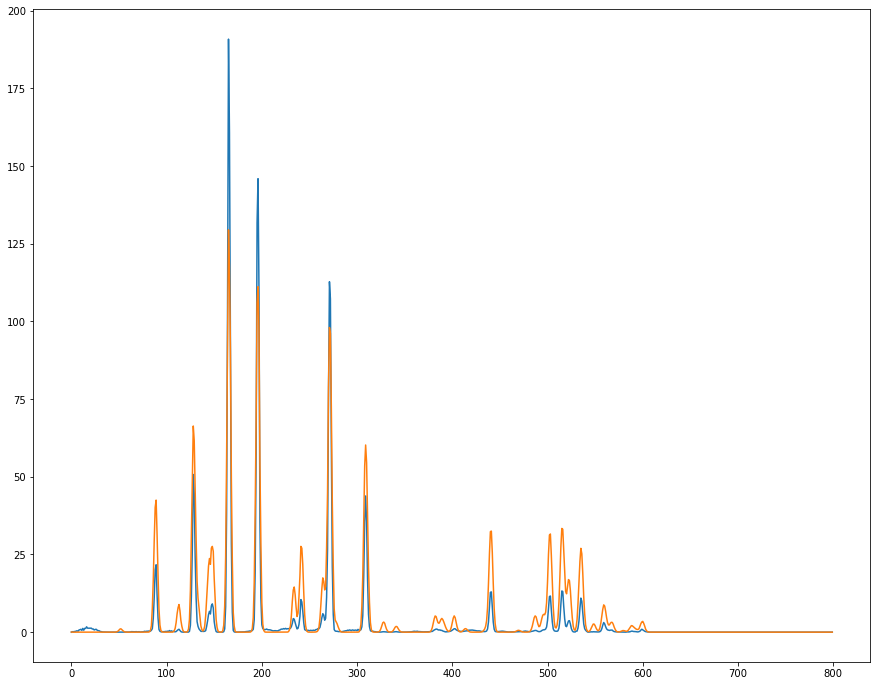

In [337]:
plt.plot(tmp0.mean(axis = 0))
plt.plot(sigmap.mean(axis = 0) * 10)
#plt.plot(totalmap.mean(axis = 0) * 10)

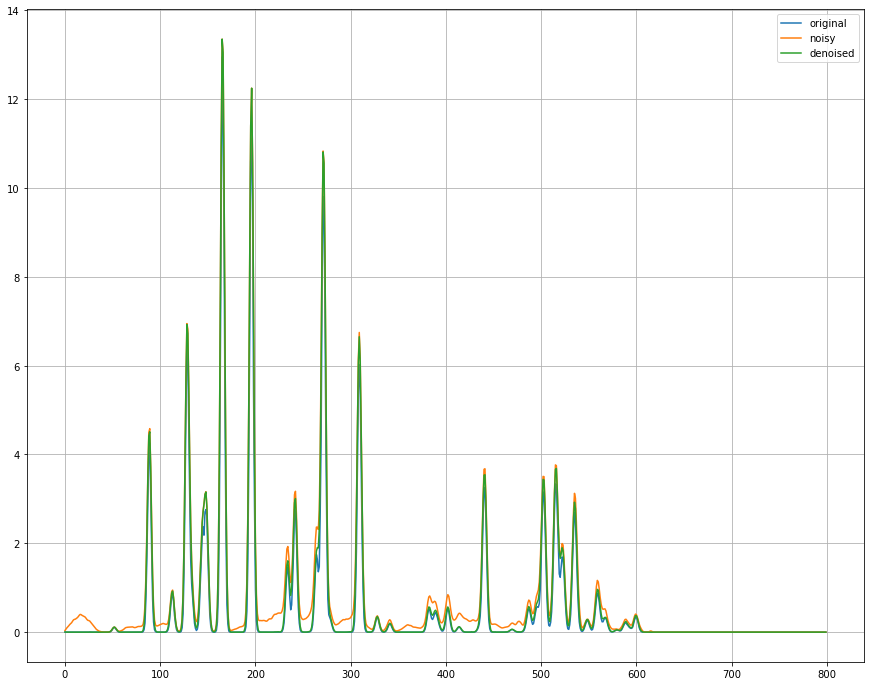

In [207]:
noise_scale = .2

plt.rcParams["figure.figsize"]=(15, 12)
plt.plot(sigmap.mean(axis = 0), label = 'original')
plt.plot(patterns.mean(axis = 0) * (1 + noise_scale), label = 'noisy')
plt.plot(denoised.mean(axis = 0) * (1 + noise_scale), label = 'denoised')
plt.grid()
plt.legend()

In [208]:
# plt.imshow(np.log10(1 + absnoise), cmap = 'jet')

# plt.imshow(mask)

#plt.imshow((~mask) * patterns, cmap = 'jet', interpolation='none')

## Experimental data

In [696]:
from scipy.interpolate import interp1d

def visual_summary(patterns, mask, denoised, vmax = 10):
    plt.rcParams["figure.figsize"]=(15, 20)

    a, b = 4, 1
    plt.subplot(a, b, 1)
    plt.imshow(np.log(1 + patterns), cmap = 'jet', vmax = vmax)
    plt.colorbar()

    plt.subplot(a, b, 2)
    plt.imshow(np.log(1 + denoised), cmap = 'jet', interpolation = 'none', vmin = 0, vmax = vmax)
    plt.colorbar()

    plt.subplot(a, b, 3)
    plt.imshow(((~mask)), interpolation = 'none')
    plt.colorbar()
    
    plt.subplot(a,b , 4)
    plt.imshow(np.log(1 + absnoise), cmap = 'jet', vmax = .1)
    plt.colorbar()
    
# def normalize_by_zeros(patterns):
#     """
#     Correct for missing pixels
#     """
#     norm = patterns.shape[0] / (1 + (patterns != 0).sum(axis = 0))
#     return norm * patterns

In [156]:
imgpaths = glob("/home/ollie/Downloads/data_for_Oliver/*pilatus*tiff")

import pyFAI
from PIL import Image
from xrdc import featurization as feat

ai = pyFAI.load("/home/ollie/Downloads/data_for_Oliver/pilatus_calibration.poni")

im = Image.open(imgpaths[20])

imarray = np.array(im)
gaps = (imarray == imarray.max())

ix, iy = np.indices(imarray.shape)

# TODO placeholder for real values
xx, yy = ix, iy

# Number of bins per dimension
boxsize = (max(xx.shape) + 1) // 2#xx.shape[0] // 2
# Number of bins per dimension in the high resolution  box
highboxsize = 2*boxsize
# Threshold for the sea level
threshold = 0.64
# Sigma for the gaussian smoothing
sigma = .5 
# Initial random seed
llavor = 0
# Spectral index for the power spectrum
indexlaw = -1.

(1043, 981)


/home/ollie/anaconda3/lib/python3.8/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")
<ipython-input-157-72a665e18b97>:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(1 + imarray + noise), cmap = 'jet')


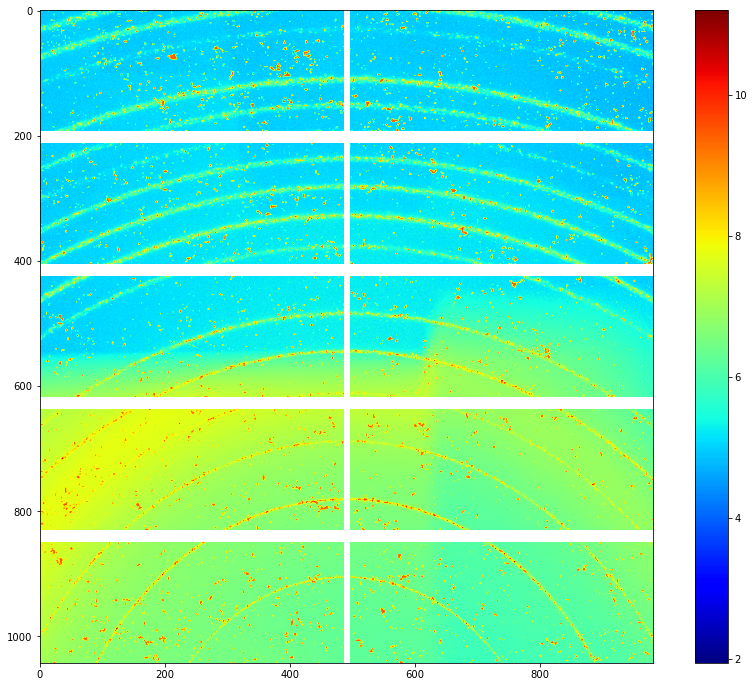

In [157]:
noise = get_speckle(300, 0.)
noise = noise * (~gaps)

I_no_noise, _, _ = ai.integrate2d(imarray, 800, npt_azim=360)
I, tth, chi = ai.integrate2d(imarray + noise, 800, npt_azim=360)
# chi = chi * (np.pi / 180)
# tth = tth * (np.pi / 180)
# (imarray * (~gaps)).mean()
# (noise * (~gaps)).mean()
plt.imshow(np.log(1 + imarray + noise), cmap = 'jet')
plt.colorbar()

(0, 0)
(0, 0)


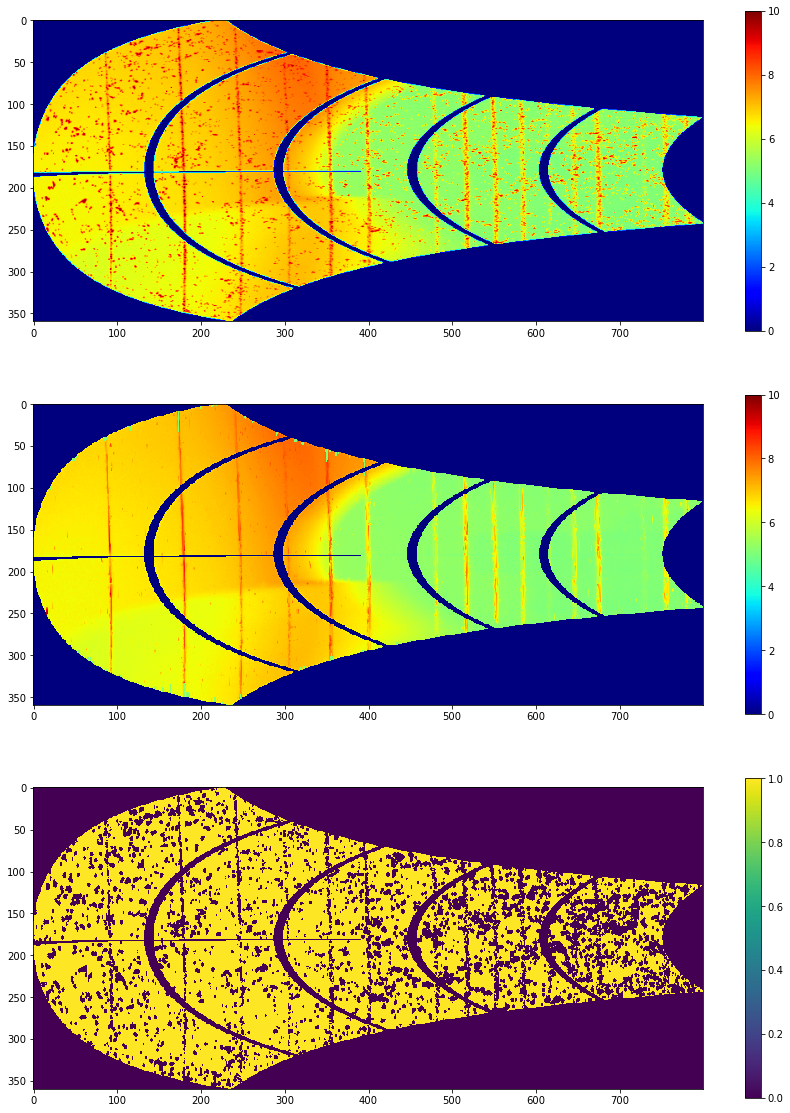

In [158]:
chi_det = ai.chi(ix, iy)
tth_det = ai.tth(ix, iy)

_aichi_idx = mk_get_idx(chi.min(), chi.max(), len(chi))
ichi = _aichi_idx(chi_det)

_aitth_idx = mk_get_idx(tth.min(), tth.max(), len(tth))
itth = _aitth_idx(tth_det)

# rawremap = np.zeros(imarray.shape)
# rawremap[ix, iy] += I[ichi, itth]
rawremap = ai.calcfrom2d(I, tth, chi)

# groundtruth_remap = np.zeros(imarray.shape)
# groundtruth_remap[ix, iy] += I_no_noise[ichi, itth]
groundtruth_remap = ai.calcfrom2d(I_no_noise, tth, chi)

patterns = I
slow_q, fast_q, slow_T, fast_T = sep.separate_signal(patterns, cutoff = .25, threshold = 20,
                                                     smooth_q = 1.7, background_after_filter = False)
background = slow_q

# plt.imshow(np.log(1 + background), cmap = 'jet')
# plt.colorbar()

denoised, mask, absnoise = denoise(patterns, method = 'linear', nthresh = 0.16, mask_smooth = .5,
                                  pre_smooth = (0, .5)) 

# TODO interpolation artifacts

# denoised_remap = np.zeros(imarray.shape)
# denoised_remap[ix, iy] += denoised[ichi, itth]
denoised_remap = ai.calcfrom2d(denoised, tth, chi)

visual_summary(patterns, mask, denoised)

In [161]:
chi.max()

-19.970268924149806

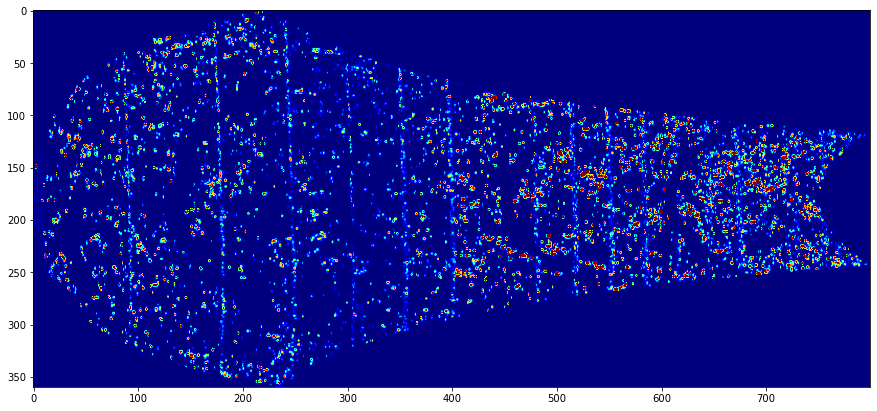

In [152]:
plt.imshow(absnoise * (patterns != 0), cmap = 'jet', vmax = 3)

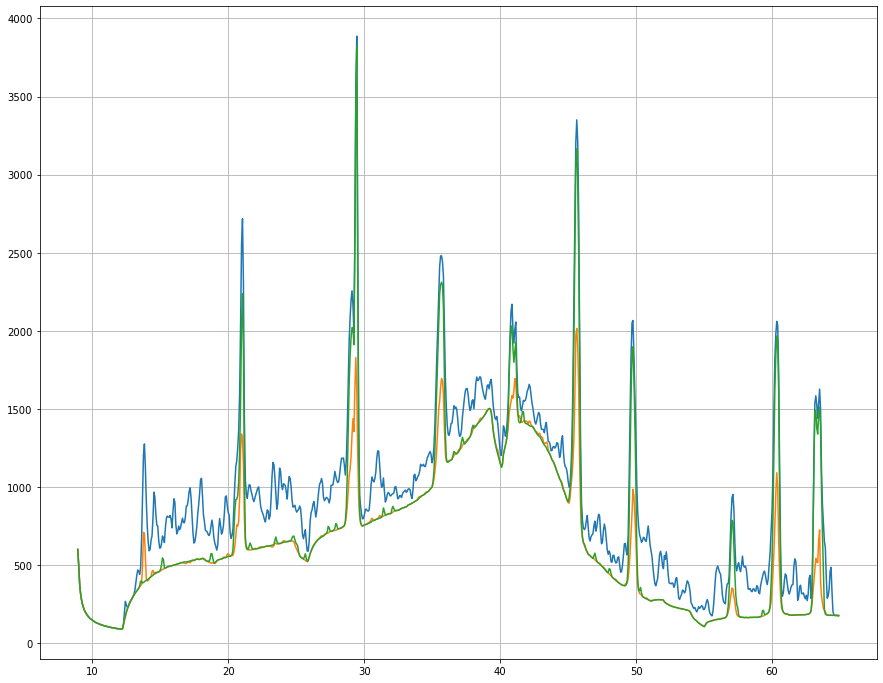

In [153]:
plt.rcParams["figure.figsize"]=(15, 12)
plt.plot(*ai.integrate1d(ai.calcfrom2d(I, tth, chi), 800))
plt.plot(*ai.integrate1d(ai.calcfrom2d(denoised, tth, chi), 800))
plt.plot(*ai.integrate1d(ai.calcfrom2d(I_no_noise, tth, chi), 800))
plt.grid()

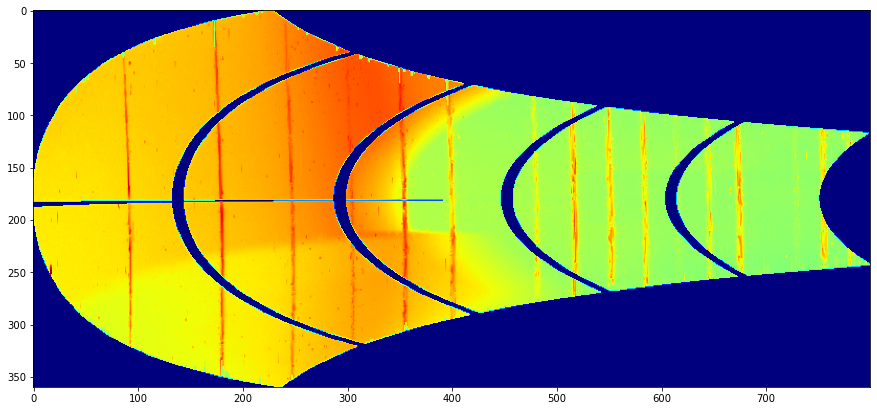

In [57]:
plt.imshow(np.log(1 + denoised), cmap = 'jet')

Text(0.5, 1.0, 'ground truth')

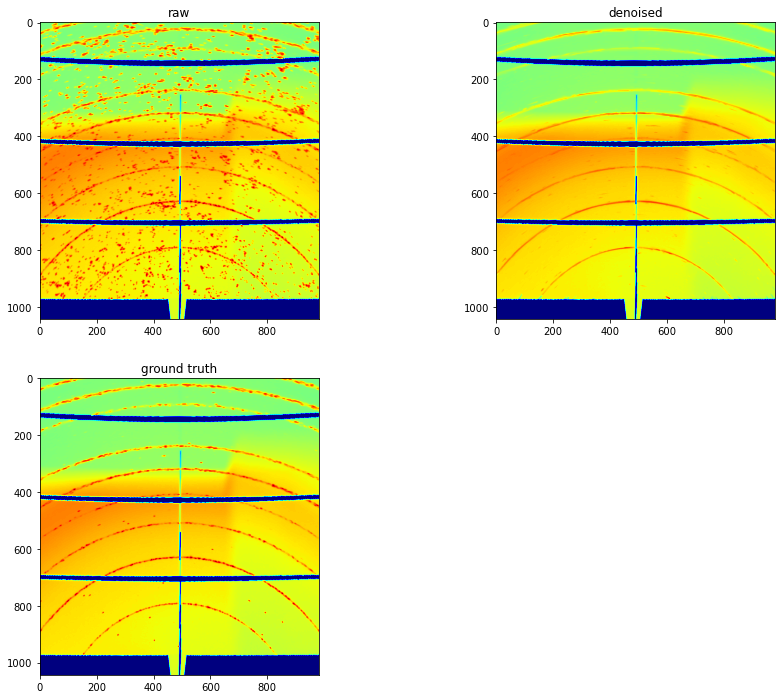

In [154]:
a, b = 2, 2
plt.subplot(a, b, 1)
plt.title('raw')
plt.imshow(np.log(1 + rawremap), cmap = 'jet', vmin = 0, vmax = 10)
#plt.colorbar()

plt.subplot(a, b, 2)
plt.imshow(np.log(1 + denoised_remap), cmap = 'jet', vmax = 10)
#plt.imshow(np.log(1 + imarray), cmap = 'jet', vmin = 0, vmax = 12)
plt.title('denoised')
#plt.colorbar()

plt.subplot(a, b, 3)
plt.imshow(np.log(1 + groundtruth_remap), cmap = 'jet', vmax = 10)
#plt.imshow(np.log(1 + imarray), cmap = 'jet', vmin = 0, vmax = 12)
plt.title('ground truth')
#plt.colorbar()

todo

Set kernel width to maximum size of variation to remove in some automated way

In [26]:
# TODO low q getting truncated?
# a, b = 1, 2
# plt.subplot(a, b, 1)
# plt.imshow(np.log(1 + rawremap), cmap = 'jet', vmin = 0, vmax = 12)
# #plt.colorbar()

# plt.subplot(a, b, 2)
# plt.imshow(np.log(1 + imarray), cmap = 'jet', vmin = 0, vmax = 12)
# plt.title('raw')
# #plt.colorbar()

In [27]:
# plt.imshow(np.log(1 + I), cmap = 'jet')

In [28]:
# sep.iplot_rows(patterns, fast_T, labels = ['raw', 'fast T'])

In [29]:
# plt.plot(np.std(fast_T, axis = 0))
# plt.plot(patterns.mean(axis = 0))

# Diffuse scattering <a class="anchor" id="diffuse"></a>

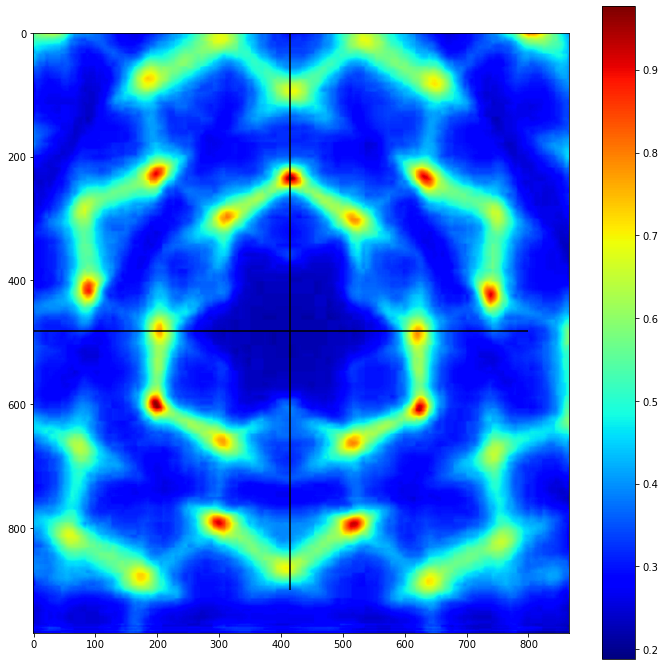

In [413]:
plt.rcParams["figure.figsize"]=(12, 12)

# Si 111 parallel to incident beam, 28keV, taken from Nielsen book
arr=plt.imread('tds111.png')# / 255
# stand in for Si TDS intensity
tds = arr[:, :, 1]

plt.imshow(tds, cmap = 'jet')
plt.vlines(415, 0, 900, 'k')
plt.hlines(482, 0, 800, 'k')
plt.colorbar()

offx, offy = (np.array(tds.shape) / 2 - np.array([482, 415])).astype(int)
tds = tds[:-offx, :-offy]

In [592]:
from skimage.transform import resize

scale = 0.64 # to correct q position of the diffuse scattering peak

tds_cropped = sep.draw_circle(tds, 290) * tds
resizex, resizey = (np.array(tds_cropped.shape) * scale).astype(int)

tds_cropped = resize(tds_cropped, (resizex, resizey))

padx, pady = np.array(detsignal.shape) - np.array(tds_cropped.shape)

xleft, xright = padx // 2, padx - padx // 2

yleft, yright = pady // 2, pady - pady // 2

tds_cropped = np.pad(tds_cropped, [(xleft, xright), (yleft, yright)])

tdmask = (sep.draw_circle(tds_cropped, int(210 * (scale / .74))) != 0)

tds_cropped = interp2d(xx[tdmask], yy[tdmask], tds_cropped[tdmask])(xx, yy)

tds_cropped = gf(tds_cropped, 2)

In [599]:
# masking / centering
# plt.imshow((tdmask.astype(bool) ^ (tds_cropped > 0)))

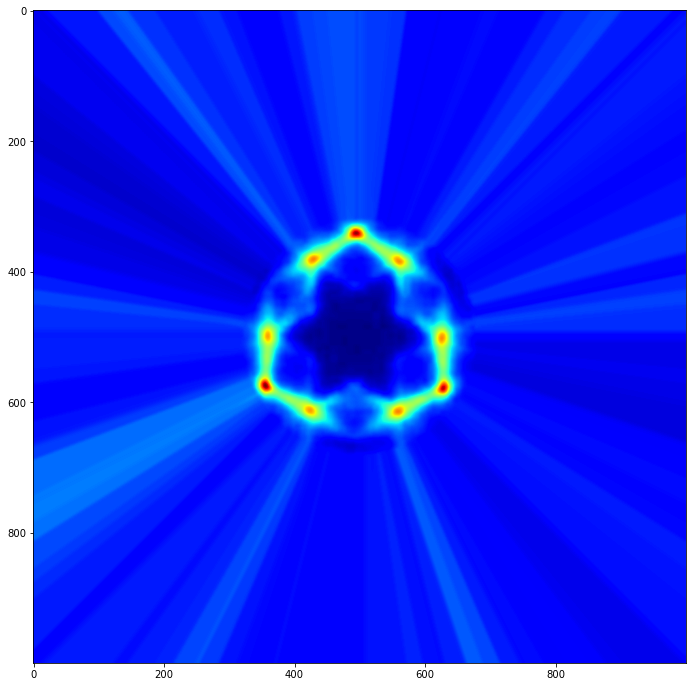

In [593]:
plt.rcParams["figure.figsize"]=(12, 12)
plt.imshow((tds_cropped), cmap = 'jet')

In [659]:
tds_chi = det_to_ttchi(tds_cropped)

In [676]:
def interp_chi(tds_chi):
    return interp2d(phiphigrid[tds_chi > 0], ttgrid[tds_chi > 0], tds_chi[tds_chi > 0])(phiphigrid, ttgrid)

In [707]:
sigmap = interp_chi(sigmap)

In [660]:
tds_chi = interp2d(phiphigrid[tds_chi > 0], ttgrid[tds_chi > 0], tds_chi[tds_chi > 0])(phiphigrid, ttgrid)

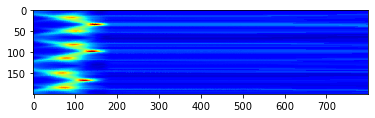

In [700]:
%matplotlib inline
plt.imshow(tds_chi, cmap = 'jet', interpolation = 'none')

<IPython.core.display.Javascript object>


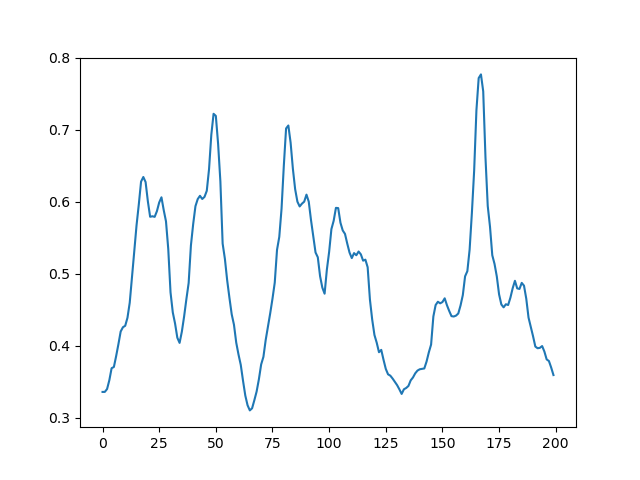

In [682]:
%matplotlib notebook
plt.plot(tds_chi[:, 110])

<IPython.core.display.Javascript object>


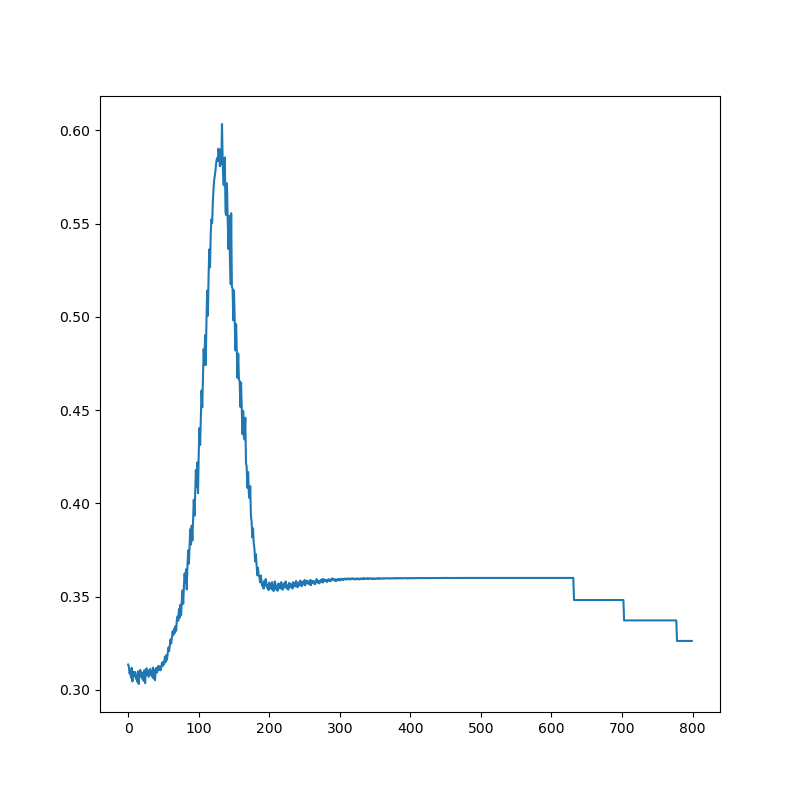

In [702]:
%matplotlib notebook
plt.rcParams["figure.figsize"]=(8, 8)

plt.plot(tds_chi[30, :])

<IPython.core.display.Javascript object>


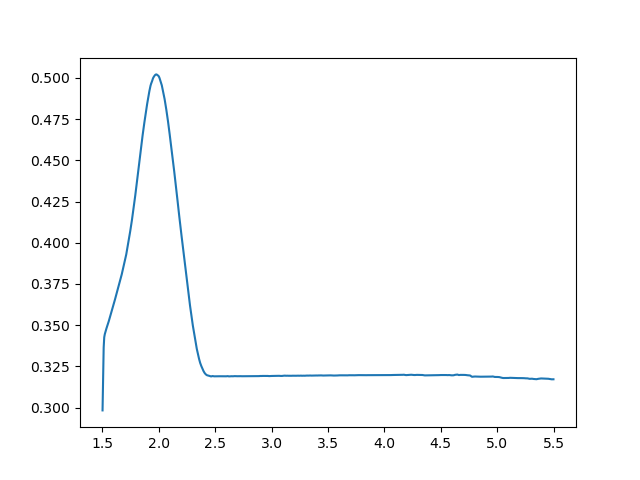

In [683]:
plt.plot(xdu.q_grid, gf(tds_chi.mean(axis = 0), 1))

In [664]:
sigmap.shape

(200, 800)

In [672]:
sigmap.max()

20.64306512697426

In [673]:
tds_chi.max()

0.9385185317798508

In [712]:
I_scale_diffuse = 10.

patterns_diffuse = sigmap + I_scale_diffuse * tds_chi
patterns_diffuse = gf(patterns_diffuse, (0.5, 1.))

In [713]:
# plt.imshow(np.log(1 + interp_chi(sigmap)), cmap = 'jet')

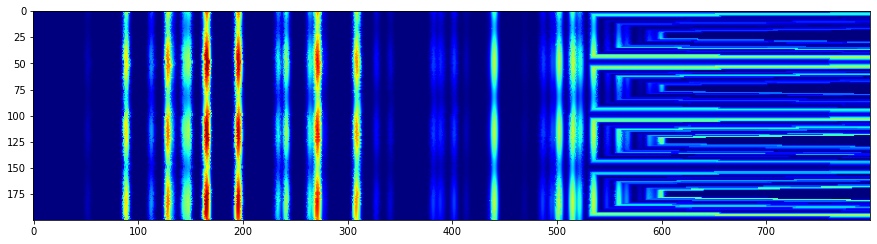

In [714]:
plt.imshow(np.log(1 + sigmap), cmap = 'jet')

In [715]:
%matplotlib inline

(10, 1.0)
(0, 0)


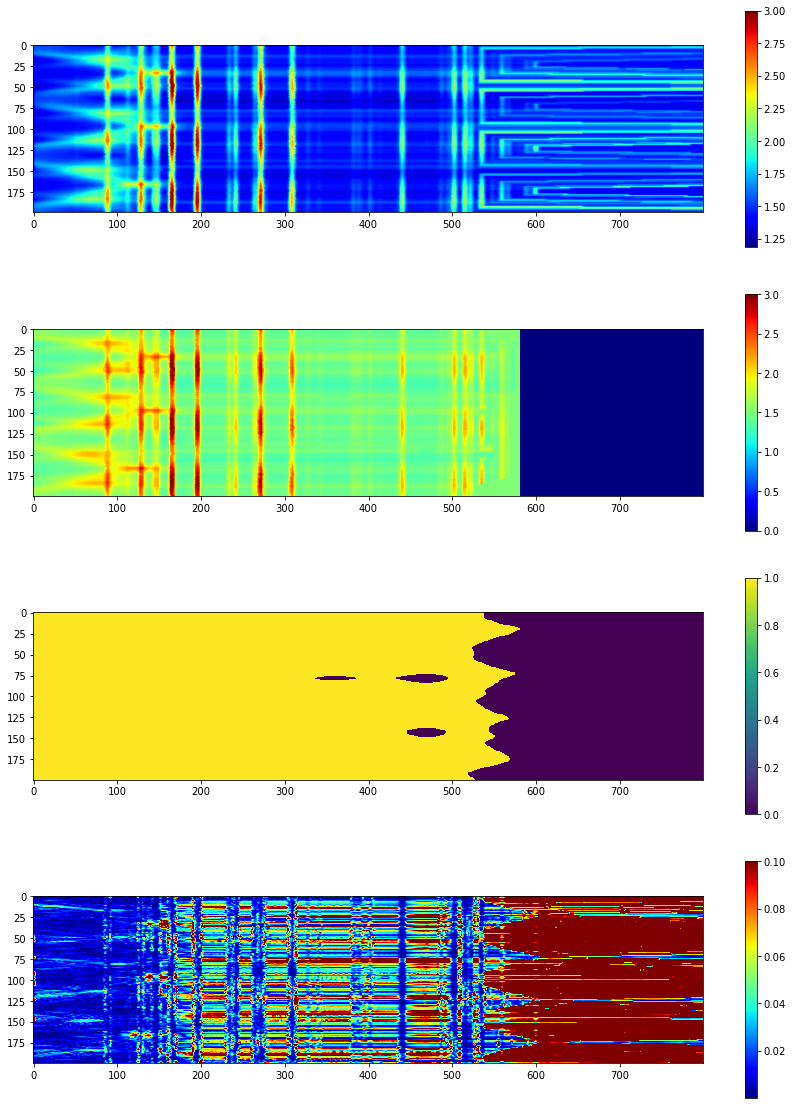

In [724]:
#denoised = sep.NDinterpolation((~mask) * patterns)

denoised, mask, absnoise = denoise(patterns_diffuse, method = 'linear', nthresh = 0.1, pre_smooth = (10, 1.),
                                  mask_smooth = (4, 20))
#denoised = sep.interprows(gf(patterns, (0., 0.)).T, (~mask).T, fill_value="extrapolate").T

visual_summary(patterns_diffuse, mask, denoised, vmax = 3)

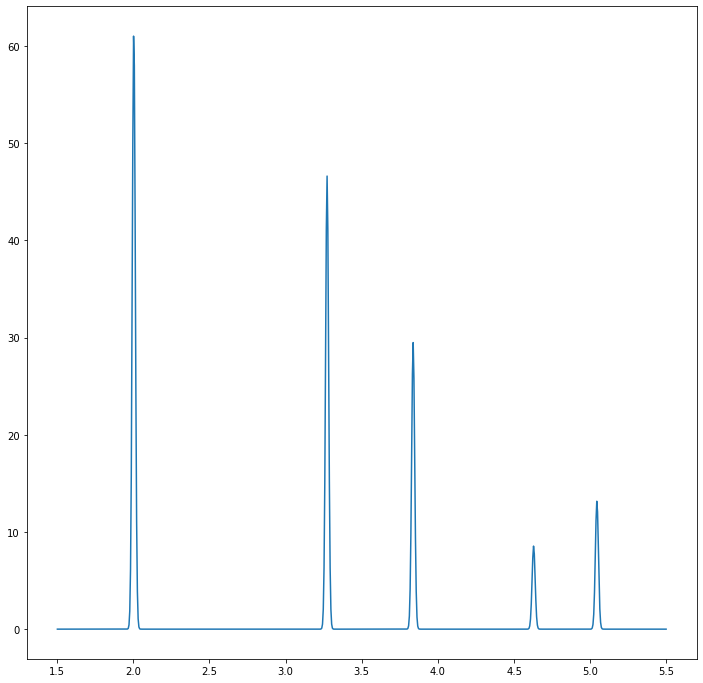

In [598]:
# Si powder diffraction for reference

from pymatgen.core import Lattice, Structure

#Si
coords = [[0, 0, 0], [0.75,0.5,0.75]]
lattice = Lattice.from_parameters(a=3.84, b=3.84, c=3.84, alpha=120,
                            beta=90, gamma=60)
struct = Structure(lattice, ["Si", "Si"], coords)

I_si = structure_pat(struct, wavelength = 1.23984198e4 / 28e3)

plt.plot(xdu.q_grid, I_si)

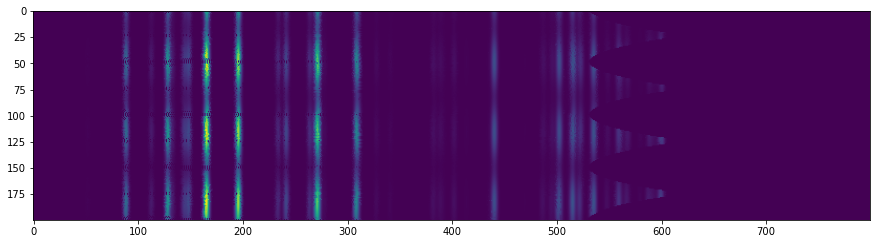

In [477]:
det_to_ttchi(detsignal)